In [1]:
from matplotlib import pyplot as plt
import numpy as np
import skimage, skimage.morphology, skimage.feature
from skimage.color import rgb2gray
from skimage import exposure
from skimage.segmentation import random_walker
%matplotlib inline

In [2]:
def find_table(pic, cannysigma=8, closure=8, threshold_stepback=1):
    hsvpic = skimage.color.rgb2hsv(pic)
    bwpic = hsvpic[:,:,2]
    satpic = hsvpic[:,:,1]
    # White is high-valued and low-saturated, so whiteness of colors is taken to be
    # directly correlated with value and inversely with saturation.
    whitepic = bwpic - satpic
    
    # The histogram should be somehow U-shaped, so the threshold is computed by taking
    # density maximum above the antimode, and then stepping back by a certain proportion
    # of the standard deviation.
    density, edges = np.histogram(whitepic.flat, bins = 40)
    # mean = np.mean(whitepic)
    antimode = skimage.filters.threshold_otsu(whitepic)
    sigma = np.std(whitepic)
    stepback = 0.5
    split = np.searchsorted(edges, antimode, side='right')
    maxd = split + np.argmax(density[split:])
    threshold = edges[maxd] - threshold_stepback*sigma
    maskpic = whitepic > threshold
    
    # The largest connected region will be selected at the table.
    # In order to disconnect nearby bright background region, Canny edges computed on
    # the hue channel (hue is chosen because we already know there wasn't enough distance
    # in brightness).
    huepic = hsvpic[:,:,0]
    cannyhue = skimage.feature.canny(huepic, sigma=cannysigma)
    # satpic = hsvpic[:,:,1]
    # cannysat = skimage.feature.canny(satpic, sigma=cannysigma)
    huesatmask = maskpic & ~cannyhue # & ~cannysat
    labeledpic = skimage.measure.label(huesatmask, connectivity=1)
    largestmask = labeledpic == np.argmax(np.bincount(labeledpic.flat)[1:])+1
    
    # A closure is computed on the mask to clean out speckles and dirt. 
    disk = skimage.morphology.disk(closure)
    return skimage.morphology.binary_closing(largestmask, selem=disk)

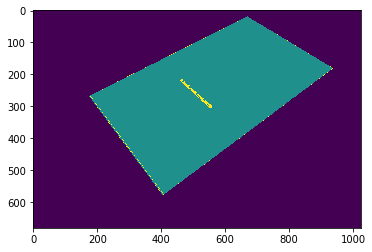

In [8]:
pic = plt.imread("pics/5.JPG")
tablemask = find_table(pic, closure=16)
# plt.imshow(tablemask)
gray=rgb2gray(pic)
p2, p98 = np.percentile(gray, (2, 98))
gray = exposure.rescale_intensity(gray, in_range=(p2, p98))
edge=skimage.feature.canny(gray, mask=tablemask, sigma=4)
# Run random walker algorithm
markers = np.zeros(gray.shape, dtype=np.uint)
markers[gray > 0.50] = 1
markers[gray < 0.80] = 2

labels = random_walker(gray, markers, beta=10, mode='bf')
labels[tablemask==False]=0
plt.imshow(labels)
plt.imsave("labels.png", labels)



In [103]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint64)